Found 7697 images belonging to 355 classes.
Found 3560 images belonging to 355 classes.
Epoch 1/250
240/240 [==============================] - 239s 941ms/step - loss: 5.8724 - accuracy: 0.0093 - val_loss: 5.7434 - val_accuracy: 0.0304
Epoch 2/250
240/240 [==============================] - 170s 709ms/step - loss: 5.7221 - accuracy: 0.0204 - val_loss: 5.5922 - val_accuracy: 0.0372
Epoch 3/250
240/240 [==============================] - 171s 714ms/step - loss: 5.5903 - accuracy: 0.0288 - val_loss: 5.4236 - val_accuracy: 0.0853
Epoch 4/250
240/240 [==============================] - 169s 702ms/step - loss: 5.4436 - accuracy: 0.0466 - val_loss: 5.2336 - val_accuracy: 0.1298
Epoch 5/250
240/240 [==============================] - 165s 686ms/step - loss: 5.2912 - accuracy: 0.0659 - val_loss: 5.0262 - val_accuracy: 0.1917
Epoch 6/250
240/240 [==============================] - 165s 686ms/step - loss: 5.1271 - accuracy: 0.0920 - val_loss: 4.8069 - val_accuracy: 0.2111
Epoch 7/250
240/240 [=========

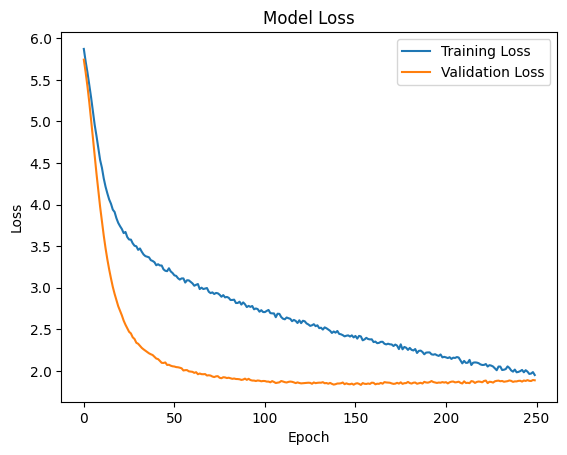

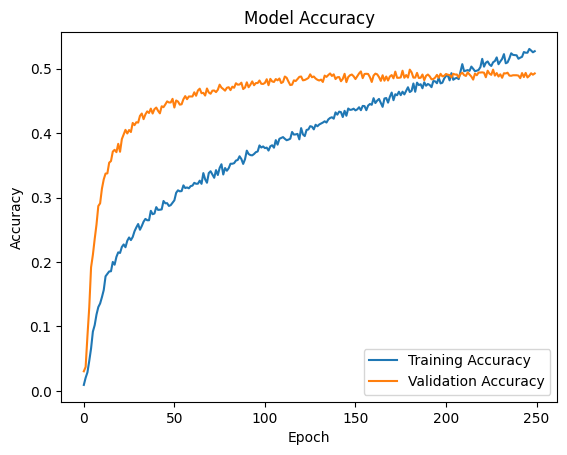

112/112 [==============================] - 19s 152ms/step
Accuracy: 0.4926966292134832
Average Precision: 0.5300675267553702
Average Recall: 0.4877604007885698
Average F1 Score: 0.4593455297925739


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import InceptionResNetV2
from skimage.transform import resize
# Define data directories
train_data_dir = r"C:\Users\79894\Downloads\archive2_converted_train"
test_data_dir = r"C:\Users\79894\Downloads\archive2_converted_test"

# Define data generators with preprocessing_function (fixed image size)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda img: crop_dog(img, [10, 10, 100, 100])  # Pass the bounding box here
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Adjusted to match the InceptionResNetV2 model input shape
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),  # Adjusted to match the InceptionResNetV2 model input shape
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Function to crop dog from image using bounding box
def crop_dog(img, bbox, target_size=(299, 299)):
    x_min, y_min, width, height = bbox
    cropped_img = img[y_min:y_min+height, x_min:x_min+width]
    resized_img = resize(cropped_img, target_size, anti_aliasing=True)
    return resized_img
    
# Load pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top of InceptionResNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(355, activation='softmax')(x)  # Adjust output neurons based on your classification task

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=250,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Extract results from the final epoch
final_epoch_results = {
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1]
}

# Print the final epoch results
print("Final Epoch Results:")
print(final_epoch_results)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate the model on test data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(validation_generator.classes, predicted_classes)

# Calculate metrics
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

precision = []
recall = []
f1_score = []

for i in range(355):  # Adjusted based on the number of classes
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision_i = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall_i = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

    # Calculate F1 score
    if precision_i + recall_i != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0

    f1_score.append(f1_score_i)

# Calculate average precision, recall, and F1 score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

# Print the metrics
print("Accuracy:", accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1_score)
